In [ ]:
# %%

os.chdir('/home/oban/Desktop/Volga/stellar-classification')
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import (Dataset, TensorDataset, DataLoader, 
                              WeightedRandomSampler, random_split)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# %%

hdul = fits.open('data/dataset3_subset2.fits')
hdul1 = fits.open('data/dataset_subset4.fits')
dataset = hdul[1].data
dataset_old = hdul1[1].data
hdul.close()
hdul1.close()

problem = np.where((dataset_old.TYPED_ID == "HD134439") | 
                   (dataset_old.TYPED_ID == "Ross  889"))
dataset_old = np.delete(dataset_old, problem)

In [ ]:
# %%

# trsvchn's answer on stackoverflow at: https://stackoverflow.com/questions/55588201/pytorch-transforms-on-tensordataset

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

class GaussianNoise(torch.nn.Module):
    def __init__(self, mean: float, sigma_r: tuple):
        super().__init__()
        self.mean = mean
        self.sigma_r = sigma_r

    def forward(self, spectra):
        sigma = torch.Tensor((1)).uniform_(*self.sigma_r).cuda()
        noise = self.mean + torch.randn_like(spectra).cuda() * sigma
        out = spectra + noise
        return out

def split_dataset(data, label, dataset, split, **kwargs):
    x = data[split]
    y = label[split]
    return dataset((x,y),**kwargs)

In [ ]:
# %%

flux_numpy = dataset.FLUX.newbyteorder().byteswap()

from eval_utils import label_field, stellar_metrics

label_f = label_field(dataset, regr=False, new=True)
# label_f_old = label_field(dataset_old, regr=False, new=False)

classes = label_f.classes
indices = label_f.ord_to_idx(classes)

splits = list(range(0,len(dataset)))

train, test_val = train_test_split(splits, test_size=0.3, 
                                   random_state=1337, stratify=indices)

ones = np.where(np.unique(classes[test_val],return_counts=True)[1] == 1)

if len(ones) != 0: 
    for i in ones[0]:
        label = label_f.idx_to_ord(i)
        idx = np.where(classes[train] == label)[0][-1]
        real_idx = train.pop(idx)
        test_val.append(real_idx)

val, test = train_test_split(test_val, test_size=0.5, 
                             random_state=1337, stratify=indices[test_val])

assert sum([len(set(classes[i])) for i in [train, val, test]]) % 3 == 0

In [ ]:
# %%

flux = torch.tensor(flux_numpy).cuda().float()
labels = torch.tensor(indices).cuda().int() #indices

gaussian_noise = GaussianNoise(mean=0,sigma_r=(0.01,0.05))

train_iter = split_dataset(flux, labels, CustomTensorDataset, 
                           train, transform=gaussian_noise)

val_iter = split_dataset(flux, labels, CustomTensorDataset, val)

test_iter = split_dataset(flux, labels, CustomTensorDataset, test)

weights = pd.Series(indices[train]).value_counts()

random_sample = WeightedRandomSampler(weights=max(weights)/weights[indices[train]].values,
                                      num_samples=len(indices[train]))

train_loader = DataLoader(train_iter, 16, sampler=random_sample)
val_loader = DataLoader(val_iter, 16)
test_loader = DataLoader(test_iter, 16)

In [ ]:
# %%

def trainer(dataloader, model, loss, optimizer):
    losses = []
    preds = []
    actuals = []
    model.train()
    for fluxes, labels in dataloader:

        labels = labels.type(torch.LongTensor).cuda()
        fluxes = fluxes.cuda()

        optimizer.zero_grad()
        class_scores = model(fluxes)
        train_loss = loss(class_scores, labels)
        train_loss.backward()
        optimizer.step()
    
        losses.append(train_loss.item())
        preds.extend(class_scores.argmax(dim=1).tolist())
        actuals.extend(labels.tolist())

    inter_sm = stellar_metrics(label_f, preds, actuals, True, False)
    f1 = inter_sm.f1_macro()
    qwk = inter_sm.two_stage_qwk('q')

    return losses, f1, qwk

def validator(dataloader, model, loss, test=False):
    losses = []
    preds = []
    actuals = []
    model.eval()
    with torch.no_grad():
        if not test:
            for fluxes, labels in dataloader:
                labels = labels.type(torch.LongTensor).cuda()
                fluxes = fluxes.cuda()

                class_scores = model(fluxes)
                val_loss = loss(class_scores, labels)
                losses.append(val_loss.item())
                preds.extend(class_scores.argmax(dim=1).tolist())
                actuals.extend(labels.tolist())

            inter_sm = stellar_metrics(label_f, preds, actuals, True, False)
            f1 = inter_sm.f1_macro()
            qwk = inter_sm.two_stage_qwk('q')

            return losses, f1, qwk

        if test:
            for fluxes, labels in dataloader:
                labels = labels.type(torch.LongTensor).cuda()
                fluxes = fluxes.cuda()

                class_scores = model(fluxes)
                class_preds = class_scores.argmax(dim=1)
                preds.extend(class_preds.tolist())
                actuals.extend(labels.tolist())

            return preds, actuals

class2coords = torch.tensor(
    label_f.to_regr(np.unique(classes),idx=False),
    dtype=torch.float32)

class OrdinalLoss(nn.Module):
    def __init__(self, class2coords, alpha, betas=[1,1]):
        super().__init__()
        # register as a buffer so it moves with .to(device), but is not trained
        self.register_buffer('coords', class2coords)  
        self.alpha = torch.tensor(alpha).cuda()
        self.betas = torch.tensor(betas).cuda()

    def forward(self, logits, target):
        probs = logits.softmax(dim=1)
        pred_xy = probs @ self.coords
        true_xy = self.coords[target]

        loss_xent = F.cross_entropy(logits, target)
        loss_ord = F.mse_loss(self.betas*pred_xy, self.betas*true_xy)
        return (1-self.alpha)*loss_xent + self.alpha*loss_ord

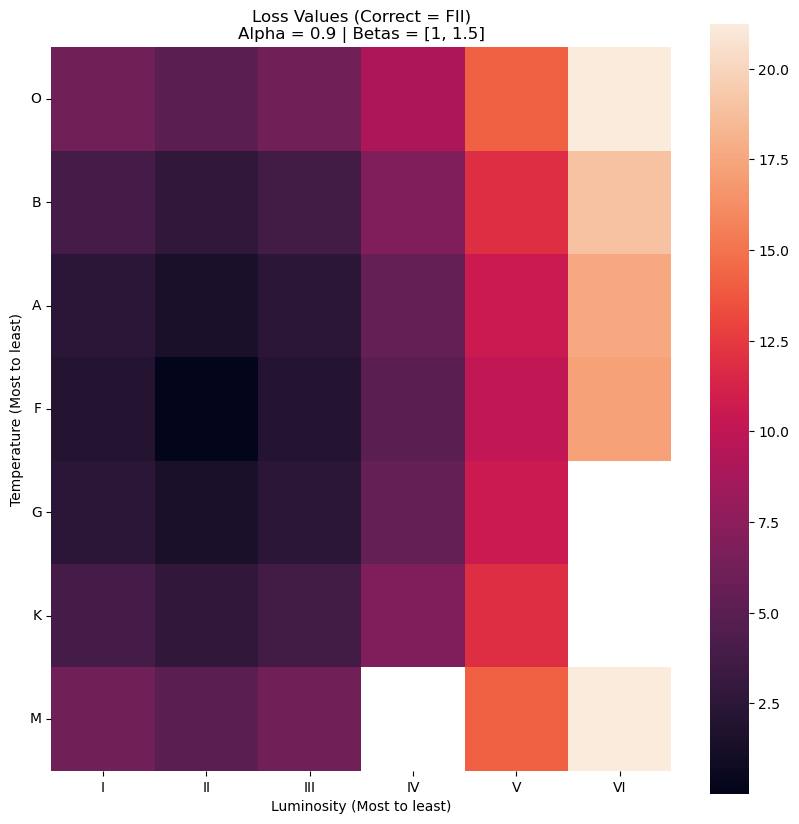

In [ ]:
# %%

alpha = 0.9
betas = [1,1.5]
correct = 19

loss = OrdinalLoss(class2coords, alpha, betas).cuda()

x = torch.zeros([12,39]).cuda()
x[:,correct] = 10

los_l = lambda y: loss(x, torch.Tensor([y]*12).type(torch.LongTensor).cuda()).item()

losses = [los_l(y) for y in range(39)]

losses.insert(37,np.nan)
losses.insert(34,np.nan)
losses.insert(29,np.nan)

plt.figure(figsize=(10,10))
sns.heatmap(np.array(losses).reshape(-1,6),
            square=True,xticklabels=label_f.strs[1],
            yticklabels=label_f.strs[0])
plt.yticks(rotation=0)
plt.ylabel('Temperature (Most to least)')
plt.xlabel('Luminosity (Most to least)')
plt.title(f'''Loss Values (Correct = {label_f.to_str(correct, True)})
Alpha = {alpha} | Betas = {betas}''');

In [ ]:
# %%

# from torchmetrics.regression import MeanAbsoluteError
from models.conv1d import StarClassifier2, StarClassifier2_old

fs = [1024//(2**i) for i in range(1,5)]
fs.insert(0,1)

model_config = {'filter_sizes':fs,
                'output_dim':len(label_f.idx_dict),
                'hidden_dim':2048,
                'dropout':0,
                'final_set':False}

torch.manual_seed(1337)
torch.cuda.manual_seed(1337)
torch.cuda.manual_seed_all(1337)

classifier2 = StarClassifier2(**model_config).to('cuda')

custom_loss = OrdinalLoss(class2coords, 0.75, betas=[1,1.5]).cuda()

adam = torch.optim.Adam(classifier2.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(adam, mode="min", factor=0.5, 
                                                patience=5, threshold = 0.001,
                                               verbose=True)

In [ ]:
# %%

path = 'models/weights/conv1d/cls/final6_test'
best_i = 44

classifier3 = StarClassifier2(**model_config).to('cuda')
classifier3.load_state_dict(torch.load(f'{path}/best_conv1d_cls_{best_i}.pth.tar'))

<All keys matched successfully>

F1 Macro: 59.72%
Mean Absolute Error: 0.22
Q-Weighted Kappa: 96.37%, 60.32%


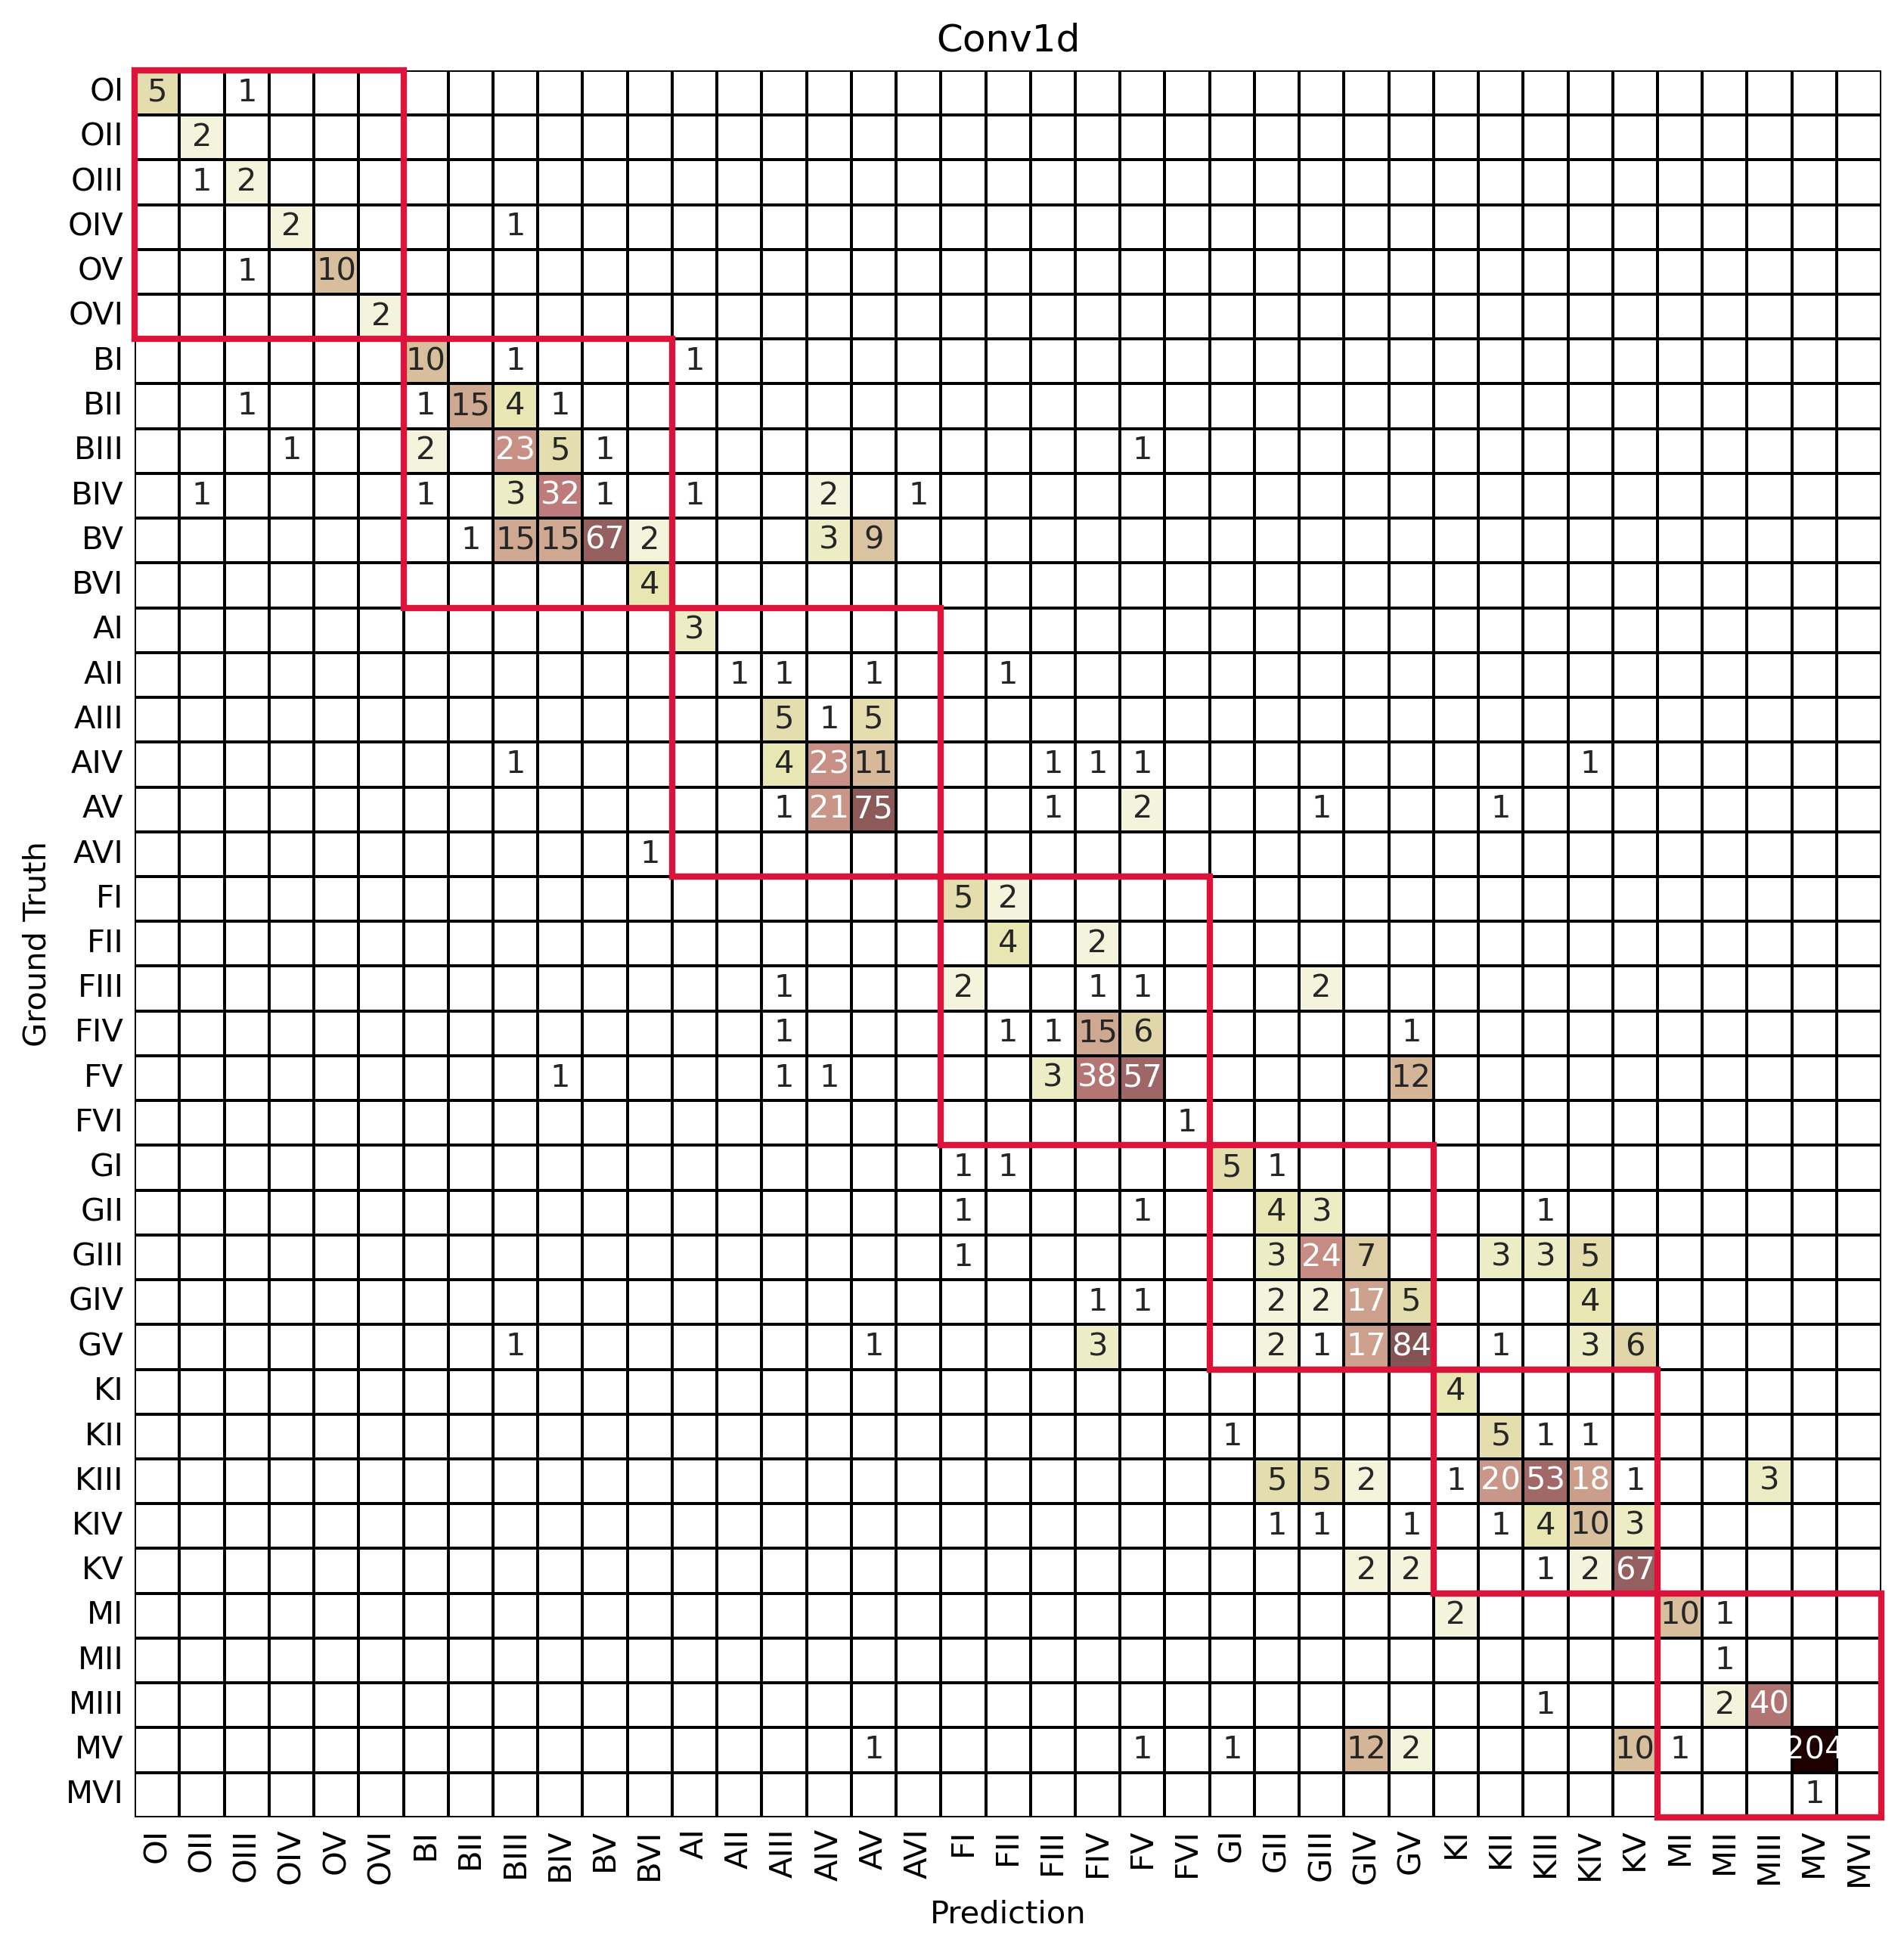

In [ ]:
# %%

preds, actuals = validator(test_loader, classifier3, custom_loss, test=True)
sm = stellar_metrics(label_f, preds, actuals, True, False)

sm.draw_cm('Conv1d', 300, False)

print(f'F1 Macro: {sm.f1_macro():.2%}')
print(f'Mean Absolute Error: {sm.mae():.2f}')
print(f'Q-Weighted Kappa: {sm.two_stage_qwk("q")[0]:.2%}, {sm.two_stage_qwk("q")[1]:.2%}')

In [ ]:
# %%

path = 'models/weights/conv1d/cls/final6_test'
best_i = 95

classifier3 = StarClassifier2(**model_config).to('cuda')
classifier3.load_state_dict(torch.load(f'{path}/best_conv1d_cls_{best_i}.pth.tar'))

<All keys matched successfully>

In [ ]:
# %%

path = 'models/weights/conv1d/cls/final6_test'
best_i = 27

classifier3 = StarClassifier2(**model_config).to('cuda')
classifier3.load_state_dict(torch.load(f'{path}/best_conv1d_cls_{best_i}.pth.tar'))

<All keys matched successfully>